## Evaluate Presidio Analyzer using the Presidio Evaluator framework

This notebook demonstrates how to evaluate a Presidio instance using the presidio-evaluator framework
Steps:
1. Load dataset from file
2. Simple dataset statistics
3. Define the AnalyzerEngine object (and its parameters)
4. Align the dataset's entities to Presidio's entities
5. Set up the Evaluator object
6. Run experiment
7. Evaluate results
8. Error analysis

For an example with a custom Presidio instance, see [notebook 5](5_Evaluate_Custom_Presidio_Analyzer.ipynb).

In [ ]:
# install presidio evaluator via pip if not yet installed

!pip install presidio-evaluator cryptography==43.0 kaleido==0.2.1 cryptography==43.0 kaleido==0.2.1

  Using cached presidio_evaluator-0.2.5-py3-none-any.whl.metadata (8.5 kB)
  Using cached faker-40.5.1-py3-none-any.whl.metadata (16 kB)
  Using cached numpy-2.4.2-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
  Using cached pandas-2.3.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached presidio_analyzer-2.2.361-py3-none-any.whl.metadata (6.2 kB)
  Using cached presidio_anonymizer-2.2.361-py3-none-any.whl.metadata (9.1 kB)
  Using cached spacy-3.8.11-cp311-cp311-win_amd64.whl.metadata (28 kB)
INFO: pip is looking at multiple versions of presidio-anonymizer to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of scikit-learn to determine which version is compatible with other requirements. This could take a while.
  Using cached scikit_learn-1.8.0-cp311-cp311-win_amd64.whl.metadata (11 kB)
INFO: pip is looking at multiple versions of scipy

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python311\\Scripts\\f2py.exe' -> 'C:\\Python311\\Scripts\\f2py.exe.deleteme'


[notice] A new release of pip is available: 24.1.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from pathlib import Path
from pprint import pprint
from collections import Counter
from typing import Dict, List
import json

from presidio_evaluator import InputSample
from presidio_evaluator.evaluation import SpanEvaluator, ModelError, Plotter
from presidio_evaluator.experiment_tracking import get_experiment_tracker

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)


ModuleNotFoundError: No module named 'presidio_evaluator'

## 1. Load dataset from file

In [3]:
dataset_name = "synth_dataset_v2.json"
dataset = InputSample.read_dataset_json(Path(Path.cwd().parent, "data", dataset_name))
print(len(dataset))

NameError: name 'InputSample' is not defined

This dataset was auto generated. See more info here [Synthetic data generation](1_Generate_data.ipynb).

In [ ]:
def get_entity_counts(dataset: List[InputSample]) -> Dict:
    """Return a dictionary with counter per entity type."""
    entity_counter = Counter()
    for sample in dataset:
        for tag in sample.tags:
            entity_counter[tag] += 1
    return entity_counter


## 2. Simple dataset statistics

In [ ]:
entity_counts = get_entity_counts(dataset)
print("Count per entity:")
pprint(entity_counts.most_common(), compact=True)

print("\nMin and max number of tokens in dataset: "\
f"Min: {min([len(sample.tokens) for sample in dataset])}, "\
f"Max: {max([len(sample.tokens) for sample in dataset])}")

print(f"Min and max sentence length in dataset: " \
f"Min: {min([len(sample.full_text) for sample in dataset])}, "\
f"Max: {max([len(sample.full_text) for sample in dataset])}")

print("\nExample InputSample:")
print(dataset[0])

Count per entity:
[('O', 19626), ('STREET_ADDRESS', 3071), ('PERSON', 1369), ('GPE', 521),
 ('ORGANIZATION', 504), ('PHONE_NUMBER', 350), ('DATE_TIME', 219),
 ('TITLE', 142), ('CREDIT_CARD', 136), ('US_SSN', 80), ('AGE', 74), ('NRP', 55),
 ('ZIP_CODE', 50), ('EMAIL_ADDRESS', 49), ('DOMAIN_NAME', 37),
 ('IP_ADDRESS', 22), ('IBAN_CODE', 21), ('US_DRIVER_LICENSE', 9)]

Min and max number of tokens in dataset: Min: 3, Max: 78
Min and max sentence length in dataset: Min: 9, Max: 407

Example InputSample:
Full text: The address of Persint is 6750 Koskikatu 25 Apt. 864
Artilleros
, CO
 Uruguay 64677
Spans: [Span(type: STREET_ADDRESS, value: 6750 Koskikatu 25 Apt. 864
Artilleros
, CO
 Uruguay 64677, char_span: [26: 83]), Span(type: ORGANIZATION, value: Persint, char_span: [15: 22])]



In [ ]:
print("A few examples sentences containing each entity:\n")
for entity in entity_counts.keys():
    samples = [sample for sample in dataset if entity in set(sample.tags)]
    if len(samples) > 1 and entity != "O":
        print(f"Entity: <{entity}> two example sentences:\n"
              f"\n1) {samples[0].full_text}"
              f"\n2) {samples[1].full_text}"
              f"\n------------------------------------\n")

A few examples sentences containing each entity:

Entity: <ORGANIZATION> two example sentences:

1) The address of Persint is 6750 Koskikatu 25 Apt. 864
Artilleros
, CO
 Uruguay 64677
2) The Exversion Orchestra was founded in 1977. Since then, it has grown from a volunteer community orchestra to a fully professional orchestra serving Southern Tunisia
------------------------------------

Entity: <STREET_ADDRESS> two example sentences:

1) The address of Persint is 6750 Koskikatu 25 Apt. 864
Artilleros
, CO
 Uruguay 64677
2) Billing address: Sara Schwarz
    28245 Puruntie 82 Apt. 595
   LAPPEENRANTA
    SK
    53650
------------------------------------

Entity: <PERSON> two example sentences:

1) Krisztián Szöllösy listed his top 20 songs for Entertainment Weekly and had the balls to list this song at #15. (What did he put at #1 you ask? Answer:"Tube Snake Boogie" by Szabina J Gelencsér ג€“ go figure)
2) My name is Rubija
------------------------------------

Entity: <DATE_TIME> two ex

## 3. Define the AnalyzerEngine object
Using Presidio with default parameters (not recommended, it's used here for simplicity). For an example on customization, see [notebook 5](5_Evaluate_Custom_Presidio_Analyzer.ipynb)

In [ ]:
from presidio_analyzer import AnalyzerEngine
# Loading the vanilla Analyzer Engine, with the default NER model.
analyzer_engine = AnalyzerEngine(default_score_threshold=0.4)

pprint(f"Supported entities for English:")
pprint(analyzer_engine.get_supported_entities("en"), compact=True)

print(f"\nLoaded recognizers for English:")
pprint([rec.name for rec in analyzer_engine.registry.get_recognizers("en", all_fields=True)], compact=True)

print(f"\nLoaded NER models:")
pprint(analyzer_engine.nlp_engine.models)

'Supported entities for English:'
['PHONE_NUMBER', 'IBAN_CODE', 'EMAIL_ADDRESS', 'US_BANK_NUMBER',
 'MEDICAL_LICENSE', 'CREDIT_CARD', 'DATE_TIME', 'UK_NHS', 'CRYPTO',
 'US_PASSPORT', 'NRP', 'MAC_ADDRESS', 'US_DRIVER_LICENSE', 'LOCATION',
 'US_ITIN', 'PERSON', 'US_SSN', 'URL', 'IP_ADDRESS']

Loaded recognizers for English:
['CreditCardRecognizer', 'UsBankRecognizer', 'UsLicenseRecognizer',
 'UsItinRecognizer', 'UsPassportRecognizer', 'UsSsnRecognizer', 'NhsRecognizer',
 'CryptoRecognizer', 'DateRecognizer', 'EmailRecognizer', 'IbanRecognizer',
 'IpRecognizer', 'MedicalLicenseRecognizer', 'MacAddressRecognizer',
 'PhoneRecognizer', 'UrlRecognizer', 'SpacyRecognizer']

Loaded NER models:
[{'lang_code': 'en', 'model_name': 'en_core_web_lg'}]


## 4. Align the dataset's entities to Presidio's entities

There is possibly a difference between the names of entities in the dataset, and the names of entities Presidio can detect.
For example, it could be that a dataset labels a name as PER while Presidio returns PERSON. To be able to compare the predicted value to the actual and gather metrics, an alignment between the entity names is necessary. Consider changing the mapping if your dataset and/or Presidio instance supports difference entity types.

In [ ]:
from presidio_evaluator.models import  PresidioAnalyzerWrapper

entities_mapping=PresidioAnalyzerWrapper.presidio_entities_map # default mapping

print("Using this mapping between the dataset and Presidio's entities:")
pprint(entities_mapping, compact=True)


dataset = SpanEvaluator.align_entity_types(
    dataset,
    entities_mapping=entities_mapping,
    allow_missing_mappings=True
)
new_entity_counts = get_entity_counts(dataset)
print("\nCount per entity after alignment:")
pprint(new_entity_counts.most_common(), compact=True)

dataset_entities = list(new_entity_counts.values())


Using this mapping between the dataset and Presidio's entities:
{'ADDRESS': 'LOCATION',
 'AGE': 'AGE',
 'BIRTHDAY': 'DATE_TIME',
 'CITY': 'LOCATION',
 'CREDIT_CARD': 'CREDIT_CARD',
 'CREDIT_CARD_NUMBER': 'CREDIT_CARD',
 'DATE': 'DATE_TIME',
 'DATE_OF_BIRTH': 'DATE_TIME',
 'DATE_TIME': 'DATE_TIME',
 'DOB': 'DATE_TIME',
 'DOMAIN': 'URL',
 'DOMAIN_NAME': 'URL',
 'EMAIL': 'EMAIL_ADDRESS',
 'EMAIL_ADDRESS': 'EMAIL_ADDRESS',
 'FACILITY': 'LOCATION',
 'FIRST_NAME': 'PERSON',
 'GPE': 'LOCATION',
 'HCW': 'PERSON',
 'HOSP': 'ORGANIZATION',
 'HOSPITAL': 'ORGANIZATION',
 'IBAN': 'IBAN_CODE',
 'IBAN_CODE': 'IBAN_CODE',
 'ID': 'ID',
 'IP_ADDRESS': 'IP_ADDRESS',
 'LAST_NAME': 'PERSON',
 'LOC': 'LOCATION',
 'LOCATION': 'LOCATION',
 'NAME': 'PERSON',
 'NATIONALITY': 'NRP',
 'NORP': 'NRP',
 'NRP': 'NRP',
 'O': 'O',
 'ORG': 'ORGANIZATION',
 'ORGANIZATION': 'ORGANIZATION',
 'PATIENT': 'PERSON',
 'PATORG': 'ORGANIZATION',
 'PER': 'PERSON',
 'PERSON': 'PERSON',
 'PHONE': 'PHONE_NUMBER',
 'PHONE_NUMBER': 'PH

## 5. Set up the Evaluator object

In [ ]:
# Set up the experiment tracker to log the experiment for reproducibility
experiment = get_experiment_tracker()

# Create the evaluator object
evaluator = SpanEvaluator(model=analyzer_engine)


# Track model and dataset params
params = {"dataset_name": dataset_name,
          "model_name": evaluator.model.name}
params.update(evaluator.model.to_log())
experiment.log_parameters(params)
experiment.log_dataset_hash(dataset)
experiment.log_parameter("entity_mappings", json.dumps(entities_mapping))

--------
Entities supported by this Presidio Analyzer instance:
PHONE_NUMBER, IBAN_CODE, EMAIL_ADDRESS, US_BANK_NUMBER, MEDICAL_LICENSE, CREDIT_CARD, DATE_TIME, UK_NHS, CRYPTO, US_PASSPORT, NRP, MAC_ADDRESS, US_DRIVER_LICENSE, LOCATION, US_ITIN, PERSON, US_SSN, URL, IP_ADDRESS


/usr/local/lib/python3.12/dist-packages/presidio_evaluator/evaluation/base_evaluator.py:83: UserWarning:

skip words not provided, using default skip words. If you want the evaluation to not use skip words, pass skip_words=[]



## 6. Run experiment

In [ ]:
%%time

## Run experiment

evaluation_results = evaluator.evaluate_all(dataset)
results = evaluator.calculate_score(evaluation_results)

# Track experiment results
experiment.log_metrics(results.to_log())
entities, confmatrix = results.to_confusion_matrix()
experiment.log_confusion_matrix(matrix=confmatrix,
                                labels=entities)

# end experiment
experiment.end()

Running model PresidioAnalyzerWrapper on dataset...
Finished running model on dataset
saving experiment data to /content/experiment_20260228-060946.json
CPU times: user 30.3 s, sys: 41.2 ms, total: 30.4 s
Wall time: 31.2 s


## 7. Evaluate results

In [ ]:
# Plot output
plotter = Plotter(results=results,
                  model_name = evaluator.model.name,
                  save_as="svg",
                  beta = 2)

# Path of the directory to save the plots
output_folder = Path(Path.cwd().parent, "plotter_output")
plotter.plot_scores(output_folder=output_folder)

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


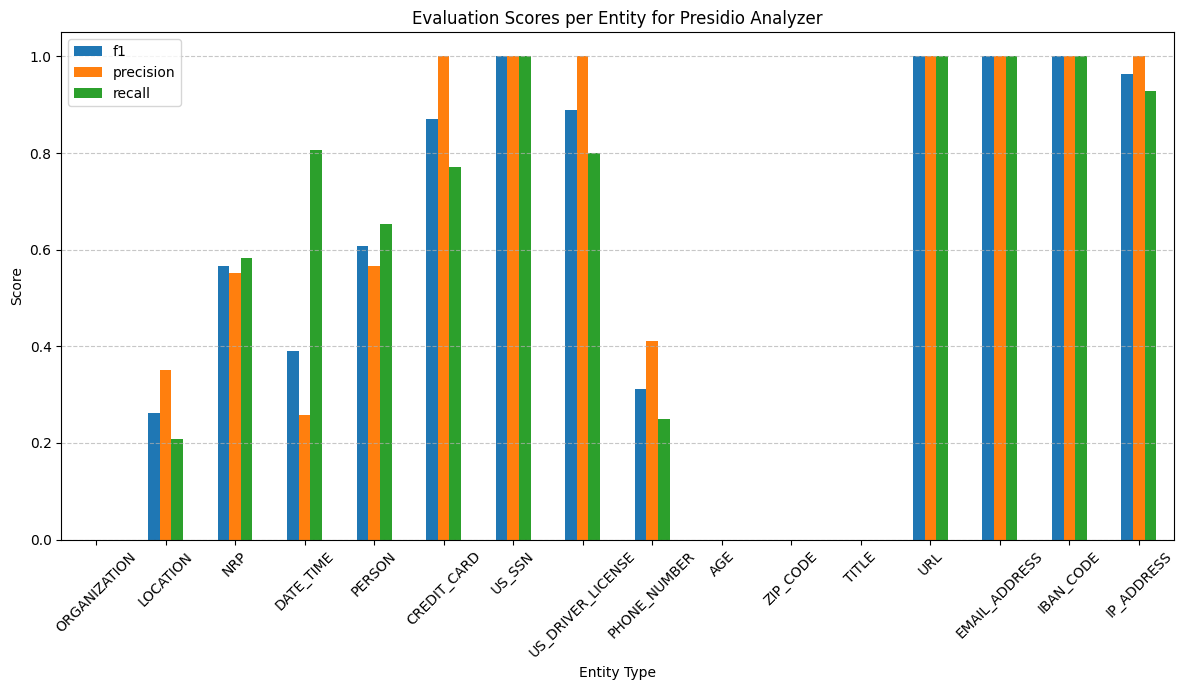

{'PII F': 0.6178033658104517,
 'PII precision': 0.6849427168576104,
 'PII recall': 0.6030259365994236}


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

# Extract scores from results object using entity_precision_dict and entity_recall_dict
scores_data = {}
for entity in results.entity_precision_dict.keys():
    if entity != 'O': # Filter out 'O' (Other) entity
        precision = results.entity_precision_dict.get(entity, 0)
        recall = results.entity_recall_dict.get(entity, 0)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        scores_data[entity] = {
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

scores_df = pd.DataFrame.from_dict(scores_data, orient='index')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(12, 7))

# Plotting F1, Precision, and Recall for each entity
scores_df[['f1', 'precision', 'recall']].plot(kind='bar', ax=ax)

ax.set_title(f'Evaluation Scores per Entity for {evaluator.model.name}')
ax.set_xlabel('Entity Type')
ax.set_ylabel('Score')
ax.set_ylim(0, 1.05) # Scores are between 0 and 1
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print overall PII metrics
pprint({"PII F":results.pii_f, "PII recall": results.pii_recall, "PII precision": results.pii_precision})

In [ ]:
pprint({"PII F":results.pii_f, "PII recall": results.pii_recall, "PII precision": results.pii_precision})

{'PII F': 0.6178033658104517,
 'PII precision': 0.6849427168576104,
 'PII recall': 0.6030259365994236}


## 8. Error analysis

Now let's look into results to understand what's behind the metrics we're getting.
Note that evaluation is never perfect. Some things to consider:
1. There's often a mismatch between the annotated span and the predicted span, which isn't necessarily a mistake. For example: `<Southern France>` compared with `Southern <France>`. In the second text, the word `Southern` was not annotated/predicted as part of the entity, but that's not necessarily an error.
1. The synthetic dataset used here isn't representative of a real dataset. Consider using more realistic datasets for evaluation

In [ ]:
plotter.plot_confusion_matrix(entities=entities, confmatrix=confmatrix, output_folder=output_folder)

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [ ]:
plotter.plot_most_common_tokens(output_folder=output_folder)

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


### 7a. False positives
#### Most common false positive tokens:

In [ ]:
ModelError.most_common_fp_tokens(results.model_errors)

#### More FP analysis

In [ ]:
fps_df = ModelError.get_fps_dataframe(results.model_errors, entity=["PERSON"])
fps_df[["full_text", "token", "annotation", "prediction"]].head(20)

### 7b. False negatives (FN)

#### Most common false negative examples + a few samples with FN

In [ ]:
ModelError.most_common_fn_tokens(results.model_errors, n=15)

#### More FN analysis

In [ ]:
fns_df = ModelError.get_fns_dataframe(results.model_errors, entity=["PHONE_NUMBER"])

In [ ]:
fns_df[["full_text", "token", "annotation", "prediction"]].head(20)